In [15]:
import os
import astropy
import numpy as np
from astropy.table import Table
from astropy.table import Column
import glob
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

In [3]:
sample_location = "/home/hallflower/sample/spectra/"
dash = "/mnt/c/users/20xha/Documents/Caltech/Research/DASH/"

In [4]:
SEDM_ML_sample = Table.read("/mnt/c/Users/20xha/Documents/Caltech/Research/SEDM_ML_sample.ascii", format = "ascii")
SEDM_ML_sample.rename_column('col1', 'ZTF_Name')
SEDM_ML_sample.rename_column('col2', "Class")
SEDM_ML_sample.rename_column('col8', "Version")

In [5]:
snidoutput = np.load("/mnt/c/Users/20xha/Documents/Caltech/Research/SNID_results_rlap3.npy", allow_pickle=True)

In [6]:
final_rcf_table = Table.from_pandas(pd.read_hdf("/mnt/c/users/20xha/Documents/Caltech/Research/final_rcf_table.h5"))

In [7]:
ZTable_best = Table(
                    names=("ZTF_Name", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0])
    good = j[1][np.where(j[1]["grade"] == "good")]
    if(len(good) != 0):
        row.append(float(np.mean(good[0]["z"])))
        row.append(float(np.sqrt(np.mean(good[0]["zerr"] ** 2))))
        ZTable_best.add_row(row)
ZTable_best_JoinedResults = astropy.table.join(ZTable_best, final_rcf_table)

In [8]:
regr_best_JoinedResults_good = linear_model.LinearRegression(fit_intercept = False)
ZTable_best_JoinedResults_good = ZTable_best_JoinedResults[np.where(ZTable_best_JoinedResults["z_host"] > -.1)[0]]
regr_best_JoinedResults_good.fit(ZTable_best_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_best_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/hallflower/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [9]:
ranges_best_good = np.linspace(0, .2, 100)
ypredict_best_good = regr_best_JoinedResults_good.predict(ranges_best_good.reshape(-1, 1))

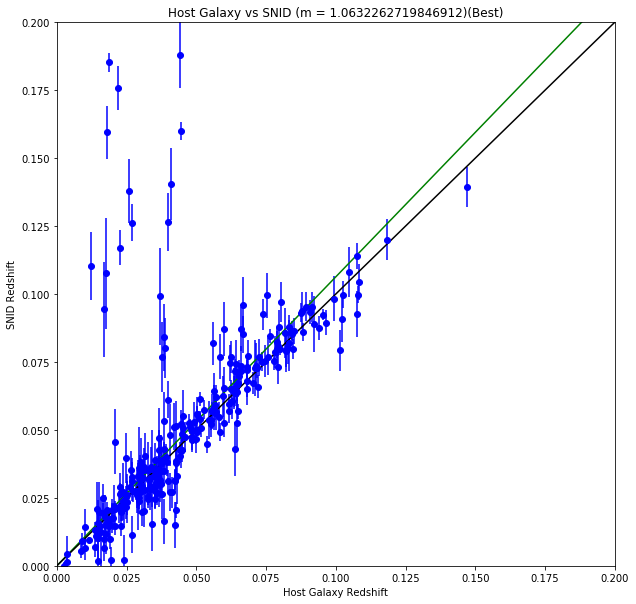

In [10]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_best_JoinedResults_good["z_host"], ZTable_best_JoinedResults_good["z_snid"], ZTable_best_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_best_JoinedResults_good.coef_[0][0]) + ")(Best)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_best_good, ypredict_best_good, color = "green")
plt.plot(ranges_best_good, ranges_best_good, color = "black")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)(Best)')

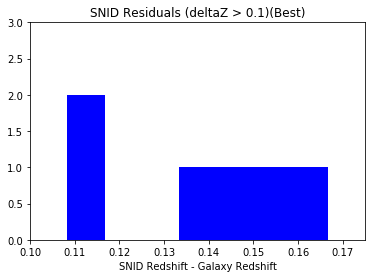

In [11]:
plt.hist(np.abs(ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.1)
plt.ylim(0,3)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)(Best)")

Text(0.5, 1.0, 'SNID Residuals (delta Z ratio > 0.5)(Best)')

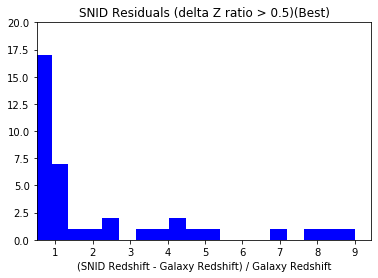

In [12]:
plt.hist(np.abs((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"])/ZTable_best_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.5)
plt.ylim(0,20)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID Residuals (delta Z ratio > 0.5)(Best)")

In [13]:
np.sum(np.abs((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"])/ZTable_best_JoinedResults_good["z_host"]) > .5)

33

Text(0.5, 1.0, 'SNID Pull (delta z / sigma z > 10)(Best)')

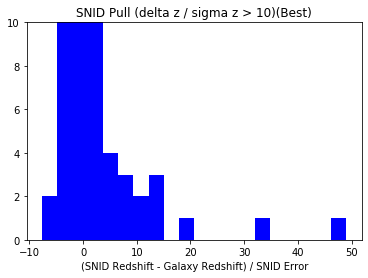

In [14]:
plt.hist(((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]) / ZTable_best_JoinedResults_good["z_snid_err"]), color = "blue", bins = 20)
plt.ylim(0,10)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / SNID Error")
plt.title("SNID Pull (delta z / sigma z > 10)(Best)")

In [19]:
print(stats.median_absolute_deviation(ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"])/ZTable_best_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]) / ZTable_best_JoinedResults_good["z_snid_err"])))

0.005820687600000003
0.16129125250229084
1.1752456153846165


In [43]:
print(np.std(ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]))
print(np.std((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]) / ZTable_best_JoinedResults_good["z_host"]))
print(np.std(((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]) / ZTable_best_JoinedResults_good["z_snid_err"])))

0.026395019710385596
1.1775633691586243
4.4315908667629


In [21]:
ZTable_average = Table(
                    names=("ZTF_Name", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0])
    good = j[1][np.where(j[1]["grade"] == "good")]
    if(len(good) != 0):
        if(np.sum(good[0:15]["zerr"] == 0) == 0):
            row.append(float(sum(good[0:15]["z"] * (1/(good[0:15]["zerr"] ** 2)))/sum(1/(good[0:15]["zerr"] ** 2))))
            row.append(float(1 / (np.sqrt(np.sum(1 / good[0:15]["zerr"] ** 2)))))
            ZTable_average.add_row(row)
ZTable_average_JoinedResults = astropy.table.join(ZTable_average, final_rcf_table)

In [22]:
regr_average_JoinedResults_good = linear_model.LinearRegression(fit_intercept = False)
ZTable_average_JoinedResults_good = ZTable_average_JoinedResults[np.where(ZTable_average_JoinedResults["z_host"] > -.1)[0]]
regr_average_JoinedResults_good.fit(ZTable_average_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_average_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/hallflower/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [23]:
ranges_average_good = np.linspace(0, .2, 100)
ypredict_average_good = regr_average_JoinedResults_good.predict(ranges_average_good.reshape(-1, 1))

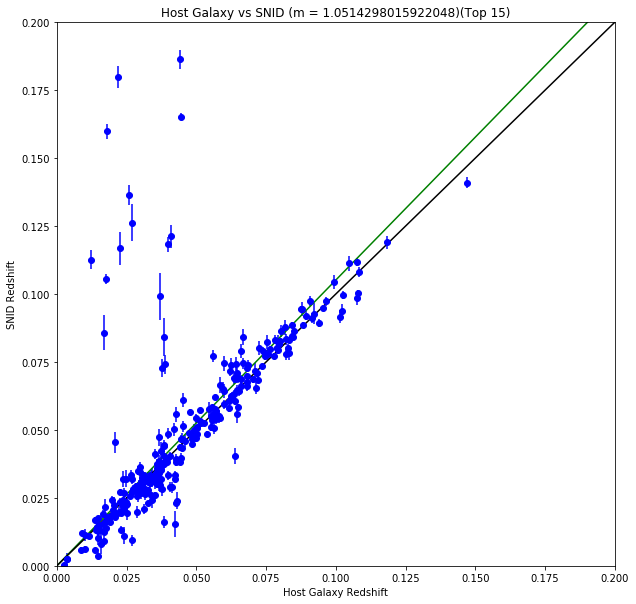

In [24]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_average_JoinedResults_good["z_host"], ZTable_average_JoinedResults_good["z_snid"], ZTable_average_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_average_JoinedResults_good.coef_[0][0]) + ")(Top 15)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_good, ypredict_average_good, color = "green")
plt.plot(ranges_average_good, ranges_average_good, color = "black")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)(Top 15)')

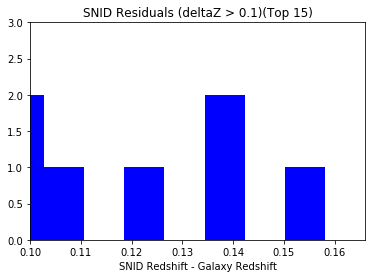

In [25]:
plt.hist(np.abs(ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.1)
plt.ylim(0,3)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)(Top 15)")

Text(0.5, 1.0, 'SNID Residuals (delta Z ratio > 0.5)(Top 15)')

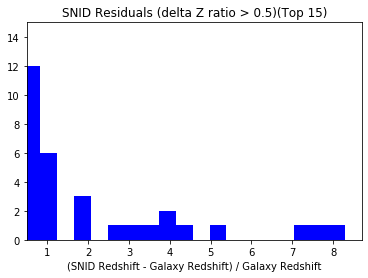

In [26]:
plt.hist(np.abs((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"])/ZTable_average_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.5)
plt.ylim(0,15)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID Residuals (delta Z ratio > 0.5)(Top 15)")

In [27]:
np.sum(np.abs((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"])/ZTable_average_JoinedResults_good["z_host"]) > .5)

26

Text(0.5, 1.0, 'SNID Pull (delta z / sigma z > 10)(Top 15)')

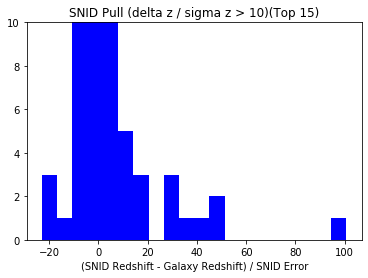

In [28]:
plt.hist(((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_snid_err"]), color = "blue", bins = 20)
plt.ylim(0,10)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / SNID Error")
plt.title("SNID Pull (delta z / sigma z > 10)(Top 15)")

In [29]:
print(stats.median_absolute_deviation(ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_snid_err"])))

0.00460442370864843
0.11469554251650586
2.9490770916348588


In [42]:
print(np.std(ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]))
print(np.std((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_host"]))
print(np.std(((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_snid_err"])))

0.02390710185812288
1.0465146044283864
9.578393058301804


In [30]:
ZTable_average_same = Table(
                    names=("ZTF_Name", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0])
    good = j[1][np.where(j[1]["grade"] == "good")]
    if(len(good) != 0):
        correct_type = j[1]["type"][0]
        correct = good[np.where(good["type"] == correct_type)[0]]
        if(len(correct) != 0):
            if(np.sum(correct[0:15]["zerr"] == 0) == 0):
                row.append(float(sum(correct[0:15]["z"] * (1/(correct[0:15]["zerr"] ** 2)))/sum(1/(correct[0:15]["zerr"] ** 2))))
                row.append(float(1 / (np.sqrt(np.sum(1 / correct[0:15]["zerr"] ** 2)))))
                ZTable_average_same.add_row(row)
ZTable_average_same_JoinedResults = astropy.table.join(ZTable_average_same, final_rcf_table)

In [31]:
regr_average_same_JoinedResults = linear_model.LinearRegression(fit_intercept = False)
ZTable_average_same_JoinedResults_good = ZTable_average_same_JoinedResults[np.where(ZTable_average_same_JoinedResults["z_host"] > -.1)[0]]
regr_average_same_JoinedResults.fit(ZTable_average_same_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_average_same_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/hallflower/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [32]:
ranges_average_same_good = np.linspace(0, .2, 100)
ypredict_average_same_good = regr_average_same_JoinedResults.predict(ranges_average_same_good.reshape(-1, 1))

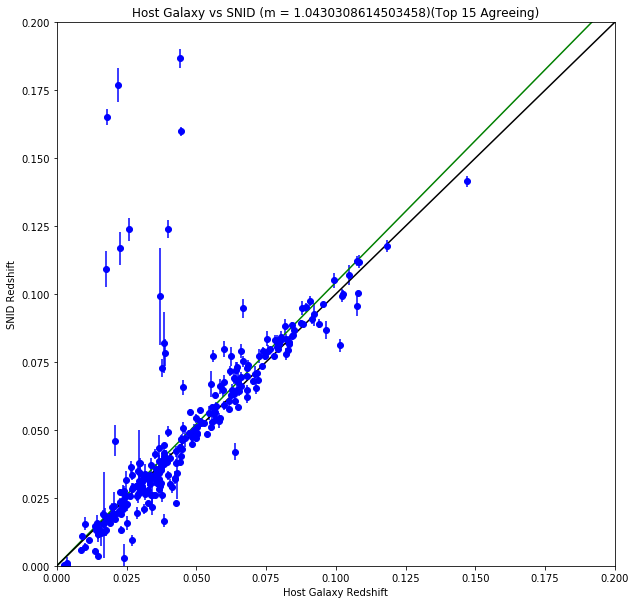

In [33]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_average_same_JoinedResults_good["z_host"], ZTable_average_same_JoinedResults_good["z_snid"], ZTable_average_same_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_average_same_JoinedResults.coef_[0][0]) + ")(Top 15 Agreeing)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_same_good, ypredict_average_same_good, color = "green")
plt.plot(ranges_average_same_good, ranges_average_same_good, color = "black")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)(Top 15 Agreeing)')

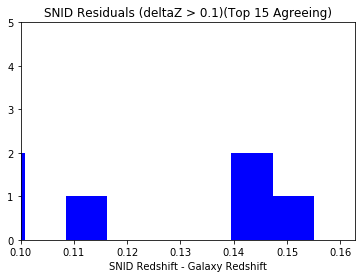

In [34]:
plt.hist(np.abs(ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.1)
plt.ylim(0,5)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)(Top 15 Agreeing)")

Text(0.5, 1.0, 'SNID Residuals (delta Z ratio > 0.5)(Top 15 Agreeing)')

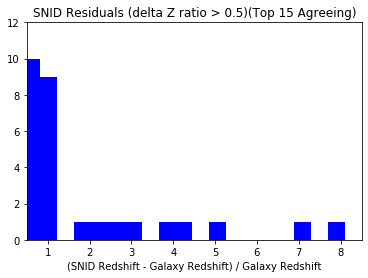

In [35]:
plt.hist(np.abs((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"])/ZTable_average_same_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.5)
plt.ylim(0,12)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID Residuals (delta Z ratio > 0.5)(Top 15 Agreeing)")

In [36]:
np.sum(np.abs((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"])/ZTable_average_same_JoinedResults_good["z_host"]) > .5)

24

Text(0.5, 1.0, 'SNID Pull (delta z / sigma z > 10)(Top 15)')

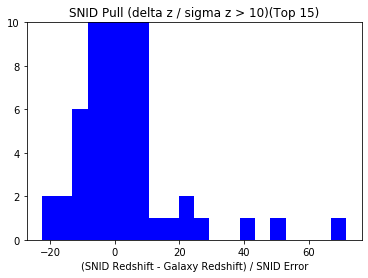

In [37]:
plt.hist(((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_snid_err"]), color = "blue", bins = 20)
plt.ylim(0,10)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / SNID Error")
plt.title("SNID Pull (delta z / sigma z > 10)(Top 15)")

In [40]:
print(stats.median_absolute_deviation(ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_snid_err"])))

0.004432155662412072
0.11672564543074172
2.7824037670529456


In [41]:
print(np.std(ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]))
print(np.std((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_host"]))
print(np.std(((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_snid_err"])))

0.021973513780981446
0.8854639291064555
7.6243493622653835
